In [230]:
# 加载数据
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import os
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_set = load('../dataresult/train_set')
    train_label = load('../dataresult/train_label')
    # 测试集
    test_set = load('../dataresult/test_set')
    test_label = load('../dataresult/test_label')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_set, train_label),
                                   batch_size=batch_size, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_set, test_label),
                                  batch_size=batch_size, num_workers=workers, drop_last=True)
    return train_loader, test_loader

batch_size = 16
# 加载数据
train_loader, test_loader = dataloader(batch_size, os.cpu_count())

print(len(train_loader))
print(len(test_loader))

16
9


In [231]:
# import torch.nn as nn
# import torchbnn as bnn

# class BayesianCNNModel(nn.Module):
#     def __init__(self, input_dim, conv_archs, output_dim):
#         super().__init__()
#         self.conv_arch = conv_archs
#         self.input_channels = input_dim
#         self.cnn_features = self.make_layers()
#         self.avgpool = nn.AdaptiveAvgPool1d(1)
#         # self.linear = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=conv_archs[-1][-1], out_features=output_dim)
#         self.mu = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=conv_archs[-1][-1], out_features=output_dim)
#         self.sigma = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=conv_archs[-1][-1], out_features=output_dim)

#     def make_layers(self):
#         layers = []
#         in_channels = self.input_channels
#         for (num_convs, out_channels) in self.conv_arch:
#             for _ in range(num_convs):
#                 layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1))
#                 layers.append(nn.ReLU(inplace=True))
#                 in_channels = out_channels
#             layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         x = x.permute(0, 2, 1)
#         x = self.cnn_features(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         # x = self.linear(x)
#         mu = self.mu(x)
#         sigma = self.sigma(x)
#         sigma = torch.exp(sigma) + 1e-6
#         return mu, sigma

# # 用法示例：
# # model = BayesianCNNModel(input_dim, conv_archs, output_dim)

In [232]:
import torch
import torch.nn as nn
from bayesian_torch.layers import Conv1dReparameterization, LinearReparameterization
import torch.nn.functional as F
class BayesianCNNModel(nn.Module):
    def __init__(self, input_dim, conv_archs, output_dim):
        super().__init__()
        self.conv_arch = conv_archs
        self.input_channels = input_dim

        # 用ModuleList存储所有卷积和激活层
        self.conv_layers = nn.ModuleList()
        in_channels = self.input_channels
        for (num_convs, out_channels) in self.conv_arch:
            for _ in range(num_convs):
                self.conv_layers.append(
                    Conv1dReparameterization(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=3,
                        padding=1,
                        prior_mean=0, prior_variance=0.1,
                        posterior_mu_init=0, posterior_rho_init=-3
                    )
                )
                self.conv_layers.append(nn.ReLU(inplace=True))
                in_channels = out_channels
            # self.conv_layers.append(nn.MaxPool1d(kernel_size=2, stride=2))

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.mu = LinearReparameterization(
            in_features=conv_archs[-1][-1], out_features=output_dim,
            prior_mean=0, prior_variance=0.1, posterior_mu_init=0, posterior_rho_init=-3
        )
        self.sigma = LinearReparameterization(
            in_features=conv_archs[-1][-1], out_features=output_dim,
            prior_mean=0, prior_variance=0.1, posterior_mu_init=0, posterior_rho_init=-3
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [batch, seq_len, in_channels] -> [batch, in_channels, seq_len]
        kl = 0.0
        for layer in self.conv_layers:
            if isinstance(layer, Conv1dReparameterization):
                x, kl_ = layer(x)
                kl += kl_
            else:
                x = layer(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        mu, kl_mu = self.mu(x)
        sigma, kl_sigma = self.sigma(x)
        sigma = torch.exp(sigma) + 1e-6
        kl += kl_mu + kl_sigma
        # mu = F.softplus(mu)
        return mu, sigma, kl

    def kl_loss(self):
        # 兼容外部调用KL损失
        kl = 0.0
        for m in self.modules():
            if hasattr(m, "kl_loss"):
                kl += m.kl_loss()
        return kl
    def alpha_divergence(self, alpha=0.5, num_samples=10):
        """
        计算模型所有贝叶斯层的alpha散度近似
        alpha: α参数，0<alpha<1，alpha=1时为KL散度
        num_samples: 采样次数
        返回：所有贝叶斯层alpha散度之和
        """
        divergence = 0.0
        for m in self.modules():
            if hasattr(m, "log_prior") and hasattr(m, "log_variational_posterior"):
                # 采样num_samples次
                log_priors = []
                log_posts = []
                for _ in range(num_samples):
                    m.sample_weights()
                    log_priors.append(m.log_prior)
                    log_posts.append(m.log_variational_posterior)
                log_priors = torch.stack(log_priors)
                log_posts = torch.stack(log_posts)
                # 计算alpha散度
                if alpha == 1.0:
                    # KL散度
                    kl = (log_posts - log_priors).mean()
                else:
                    # alpha散度
                    log_ratio = alpha * log_posts + (1 - alpha) * log_priors
                    log_mean = torch.logsumexp(log_ratio, dim=0) - torch.log(torch.tensor(num_samples, dtype=log_ratio.dtype))
                    kl = (1 / (alpha * (alpha - 1))) * (log_mean - log_posts.mean())
                divergence += kl
        return divergence

In [233]:
from loss_function import compute_au_nll
# 定义模型参数
input_dim = 14   # 输入维度为14维数据
# CNN 网络结构 参考经典CNN网络模型 VGG 必看，不然看不懂相关参数设置
conv_archs = ((1, 32), (1, 64), (1, 128))  # 层数，和每层通道数
output_dim = 1 # 输出维度为 1

model = BayesianCNNModel(input_dim, conv_archs, output_dim)  

# 定义损失函数和优化函数
# loss_function = nn.MSELoss()  # loss
# def compute_au_nll(targets: torch.Tensor, 
#                   mean: torch.Tensor, 
#                   sigma: torch.Tensor) -> torch.Tensor:
#     """计算Aleatoric Uncertainty NLL损失
#     torch.square(targets - mean) * torch.exp(-sigma)
#     """
#     s = torch.square(targets - mean)
#     loss1 = torch.mul(torch.exp(-sigma), s)
#     loss2 = sigma
#     loss = 0.5 * (loss1 + loss2)
#     return loss.mean()
loss_function = compute_au_nll

def mc_forward(model, x, n_forward=10):
    """
    对输入x进行n_forward次MC采样前向传播，返回所有采样的mu、sigma和kl
    """
    mus = []
    sigmas = []
    kls = []
    for _ in range(n_forward):
        mu, sigma, kl = model(x)
        mus.append(mu)
        sigmas.append(sigma)
        kls.append(kl)
    mus = torch.stack(mus)      # [n_forward, batch, output_dim]
    sigmas = torch.stack(sigmas)
    kls = torch.stack(kls)
    return mus, sigmas, kls


learn_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

  1344
  1344
    32
    32
  6144
  6144
    64
    64
 24576
 24576
   128
   128
   128
   128
     1
     1
   128
   128
     1
     1
______
 65092


In [234]:
print(model)

BayesianCNNModel(
  (conv_layers): ModuleList(
    (0): Conv1dReparameterization()
    (1): ReLU(inplace=True)
    (2): Conv1dReparameterization()
    (3): ReLU(inplace=True)
    (4): Conv1dReparameterization()
    (5): ReLU(inplace=True)
  )
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (mu): LinearReparameterization()
  (sigma): LinearReparameterization()
)


Epoch:  1 train_MSE-Loss: 0.73883419
Epoch:  2 train_MSE-Loss: 0.53027569
Epoch:  3 train_MSE-Loss: 0.37429580
Epoch:  4 train_MSE-Loss: 0.25868235
Epoch:  5 train_MSE-Loss: 0.14672157
Epoch:  6 train_MSE-Loss: 0.10002054
Epoch:  7 train_MSE-Loss: 0.07519962
Epoch:  8 train_MSE-Loss: 0.06305677
Epoch:  9 train_MSE-Loss: 0.06821927
Epoch: 10 train_MSE-Loss: 0.05914011
Epoch: 11 train_MSE-Loss: 0.04531223
Epoch: 12 train_MSE-Loss: 0.06038642
Epoch: 13 train_MSE-Loss: 0.04286651
Epoch: 14 train_MSE-Loss: 0.06200527
Epoch: 15 train_MSE-Loss: 0.03324994
Epoch: 16 train_MSE-Loss: 0.04455319
Epoch: 17 train_MSE-Loss: 0.09108513
Epoch: 18 train_MSE-Loss: 0.02443601
Epoch: 19 train_MSE-Loss: 0.02448840
Epoch: 20 train_MSE-Loss: 0.04075584
Epoch: 21 train_MSE-Loss: 0.03631203
Epoch: 22 train_MSE-Loss: 0.06084019
Epoch: 23 train_MSE-Loss: 0.04245910
Epoch: 24 train_MSE-Loss: 0.04348800
Epoch: 25 train_MSE-Loss: 0.03757158
Epoch: 26 train_MSE-Loss: 0.05198831
Epoch: 27 train_MSE-Loss: 0.02654975
E

findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsof

Epoch: 500 train_MSE-Loss: 0.01002509

Duration: 509 seconds


findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.


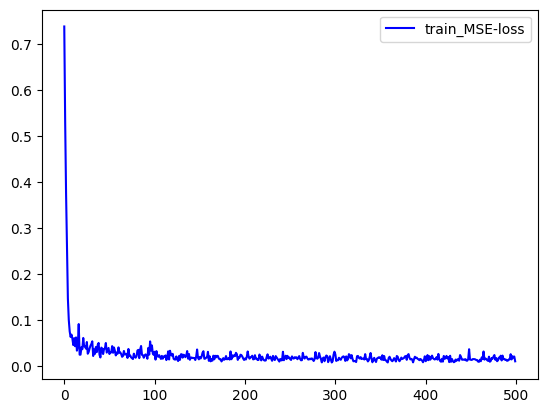

min_MSE: 0.007484081863367464


In [235]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import torchbnn as bnn

matplotlib.rc("font", family='Microsoft YaHei')

def model_train(epochs, model, optimizer, loss_function, train_loader, device, kl_weight=0.01):
    model = model.to(device)

    minimum_mse = 1000.
    best_model = model
    train_mse = []

    start_time = time.time()
    # kl_loss_fn = bnn.BKLLoss(reduction='mean', last_layer_only=False)
    for epoch in range(epochs):
        model.train()
        train_mse_loss = []
        for seq, labels in train_loader:
            seq, labels = seq.to(device), labels.to(device)
            optimizer.zero_grad()
            # mu, sigma = model(seq)
            # loss = loss_function(labels, mu, sigma)
            # kl_loss = kl_loss_fn(model)
            # total_loss = loss + kl_weight * kl_loss

            # mu, sigma, kl = model(seq)
            mus, sigmas, kls = mc_forward(model, seq, n_forward=5)
            mu_mean = mus.mean(dim=0)
            sigma_mean = sigmas.mean(dim=0)
            kl_mean = kls.mean()
            loss = loss_function(labels, mu_mean, sigma_mean)
            total_loss = loss + kl_weight * kl_mean

            train_mse_loss.append(loss.item())  # 只统计MSE
            total_loss.backward()
            optimizer.step()
        train_av_mseloss = np.average(train_mse_loss)
        train_mse.append(train_av_mseloss)
        print(f'Epoch: {epoch+1:2} train_MSE-Loss: {train_av_mseloss:10.8f}')
        if train_av_mseloss < minimum_mse:
            minimum_mse = train_av_mseloss
            best_model = model
    torch.save(best_model, 'best_model_cnn.pt')
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    plt.plot(range(epochs), train_mse, color = 'b',label = 'train_MSE-loss')
    plt.legend()
    plt.show()
    print(f'min_MSE: {minimum_mse}')

#  模型训练
epochs = 500
model_train(epochs, model, optimizer, loss_function, train_loader, device, kl_weight=0.01)

### 第一部分，训练集评估

In [236]:
# 模型预测
# 模型 测试集 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('best_model_cnn.pt', weights_only=False)
model = model.to(device)

# 预测数据
origin_data = []
pre_data = []
with torch.no_grad():
        for data, label in train_loader:
            # 原始标签
            origin_lable = label.tolist()
            origin_data += origin_lable
            model.eval()  # 将模型设置为评估模式
            
            # 预测
            data, label = data.to(device), label.to(device)
            # mu, sigma, kl = model(data)  # 对测试集进行预测
            mus, sigmas, kls = mc_forward(model, data, n_forward=5)
            mu_mean = mus.mean(dim=0)
            sigma_mean = sigmas.mean(dim=0)
            kl_mean = kls.mean()
            train_pred = mu_mean.tolist()
            pre_data += train_pred      

In [237]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 反归一化处理
# 使用相同的均值和标准差对预测结果进行反归一化处理
# 反标准化
scaler  = load('../dataresult/scaler')
origin_data = scaler.inverse_transform(origin_data)
pre_data = scaler.inverse_transform(pre_data)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 模型分数
score = r2_score(origin_data, pre_data)
print('训练集上 模型分数-R^2:',score)

print('*'*50)
# 训练集上的预测误差
train_mse = mean_squared_error(origin_data, pre_data)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(origin_data, pre_data)
print('训练数据集上的均方误差-MSE: ',train_mse)
print('训练数据集上的均方根误差-RMSE: ',train_rmse)
print('训练数据集上的平均绝对误差-MAE: ',train_mae)

训练集上 模型分数-R^2: 0.9801316662804429
**************************************************
训练数据集上的均方误差-MSE:  0.00138643019689416
训练数据集上的均方根误差-RMSE:  0.0372347981986496
训练数据集上的平均绝对误差-MAE:  0.02859535916198541


/opt/conda/envs/py39/lib/python3.9/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# 测试集评估

In [238]:
# 模型 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('best_model_cnn.pt', weights_only=False)
model = model.to(device)

# 预测数据
test_origin_data = []
test__pre_data = []
with torch.no_grad():
        for data, label in test_loader:
            # 原始标签
            origin_lable = label.tolist()
            test_origin_data += origin_lable
            model.eval()  # 将模型设置为评估模式
            
            # 预测
            data, label = data.to(device), label.to(device)
            # mu, sigma, kl = model(data)  # 对测试集进行预测
            mus, sigmas, kls = mc_forward(model, data, n_forward=100)
            mu_mean = mus.mean(dim=0)
            sigma_mean = sigmas.mean(dim=0)
            kl_mean = kls.mean()
            test_pred = mu_mean.tolist()
            test__pre_data += test_pred        

In [239]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 反归一化处理
# 使用相同的均值和标准差对预测结果进行反归一化处理
# 反标准化
scaler  = load('../dataresult/scaler')
test_origin_data = scaler.inverse_transform(test_origin_data)
test__pre_data = scaler.inverse_transform(test__pre_data)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 模型分数
score = r2_score(test_origin_data, test__pre_data)
print('测试集上 模型分数-R^2:',score)

print('*'*50)
# 训练集上的预测误差
test_mse = mean_squared_error(test_origin_data, test__pre_data)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_origin_data, test__pre_data)
print('测试数据集上的均方误差-MSE: ',test_mse)
print('测试数据集上的均方根误差-RMSE: ',test_rmse)
print('测试数据集上的平均绝对误差-MAE: ',test_mae)

测试集上 模型分数-R^2: 0.980972882054623
**************************************************
测试数据集上的均方误差-MSE:  0.0013169874237468893
测试数据集上的均方根误差-RMSE:  0.03629032135083526
测试数据集上的平均绝对误差-MAE:  0.030243587167774186


/opt/conda/envs/py39/lib/python3.9/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
/opt/conda/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23551 (\N{CJK UNIFIED IDEOGRAPH-5BFF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21629 (\N{CJK UNIFIED IDEOGRAPH-547D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30334 (\N{CJK UNIFIED IDEOGRAPH-767E}) missing from font(s) De

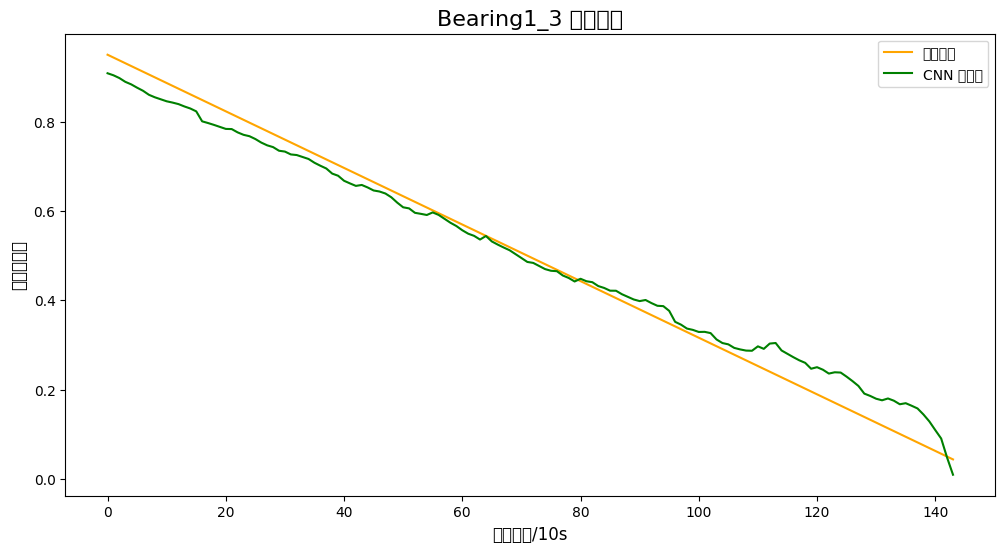

['../画图对比/cnn_pre']

In [240]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')

# 可视化结果
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_origin_data, label='真实寿命',color='orange')  # 真实值
plt.plot(test__pre_data, label='CNN 预测值',color='green')  # 预测值

# plt.plot([-1,170],[2.0*0.7,2.0*0.7],c='black',lw=1,ls='--')  # 临界点直线  可自己调整位置

plt.xlabel('运行周期/10s', fontsize=12)
plt.ylabel('寿命百分比', fontsize=12)
plt.title('Bearing1_3 预测结果', fontsize=16)
plt.legend()
plt.show()

# 保存数据
# 保存数据
dump(test_origin_data, '../画图对比/cnn_origin') 
dump(test__pre_data, '../画图对比/cnn_pre') 